In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import variation
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import ensemble

from sklearn.metrics import mean_squared_error

%matplotlib inline

# Read data

In [3]:
data_all = pd.read_csv('communities.data', header=None)

#the first 5 colums are not predictive
data = data_all.values[:, 5: -1]
label = data_all.values[:, -1].astype(np.float)

#delete some colums from DataFrame
#data.drop(colums=[1, 2, 3, 4])

#clean the data
#convert string '?' to 'NaN'
data = np.array([['NaN' if col=='?' else col for col in row] for row in data])
#convert string to corresponding number


# data_training = data.iloc[:1495, :]
# data_testing = data.iloc[1495:, :]
data_training = data[:1495, :]
data_testing = data[1495:, :]

label_training = label[:1495] 
label_testing = label[1495:]


# Deal with the missing value

In [4]:
si = Imputer(missing_values=np.nan, strategy='mean', axis=0)
si.fit(data_training)

train_imputed = si.transform(data_training)
test_imputed = si.transform(data_testing)

print(train_imputed)
print(test_imputed)

[[ 0.19        0.33        0.02       ...,  0.5         0.32        0.14      ]
 [ 0.          0.16        0.12       ...,  0.45188285  0.          0.19075314]
 [ 0.          0.42        0.49       ...,  0.45188285  0.          0.19075314]
 ..., 
 [ 0.01        0.36        0.95       ...,  0.45188285  0.          0.19075314]
 [ 0.06        0.53        0.01       ...,  0.45188285  0.          0.19075314]
 [ 0.05        0.43        0.08       ...,  0.          0.51        0.18      ]]
[[ 0.          0.2         0.03       ...,  0.45188285  0.          0.19075314]
 [ 0.          0.55        0.13       ...,  0.45188285  0.          0.19075314]
 [ 0.          0.52        0.04       ...,  0.45188285  0.          0.19075314]
 ..., 
 [ 0.16        0.37        0.25       ...,  0.          0.91        0.28      ]
 [ 0.08        0.51        0.06       ...,  0.          0.22        0.18      ]
 [ 0.2         0.78        0.14       ...,  0.5         1.          0.13      ]]


# Correlation Matrix

In [5]:
# print(pd.DataFrame(train_imputed).corr())

# plt.figure(figsize=(8, 8))
# plt.matshow(pd.DataFrame(train_imputed).corr())

# Coeficient of Variation CV 
* cv = s/m where s denotes sample variance and m denotes sample mean.
* how to derive valuable information from scatter plot?
    From the scatter plot between label and variable, we're able to infer the insignificant features, such as feature 6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aff6ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1c4586a0>]], dtype=object)

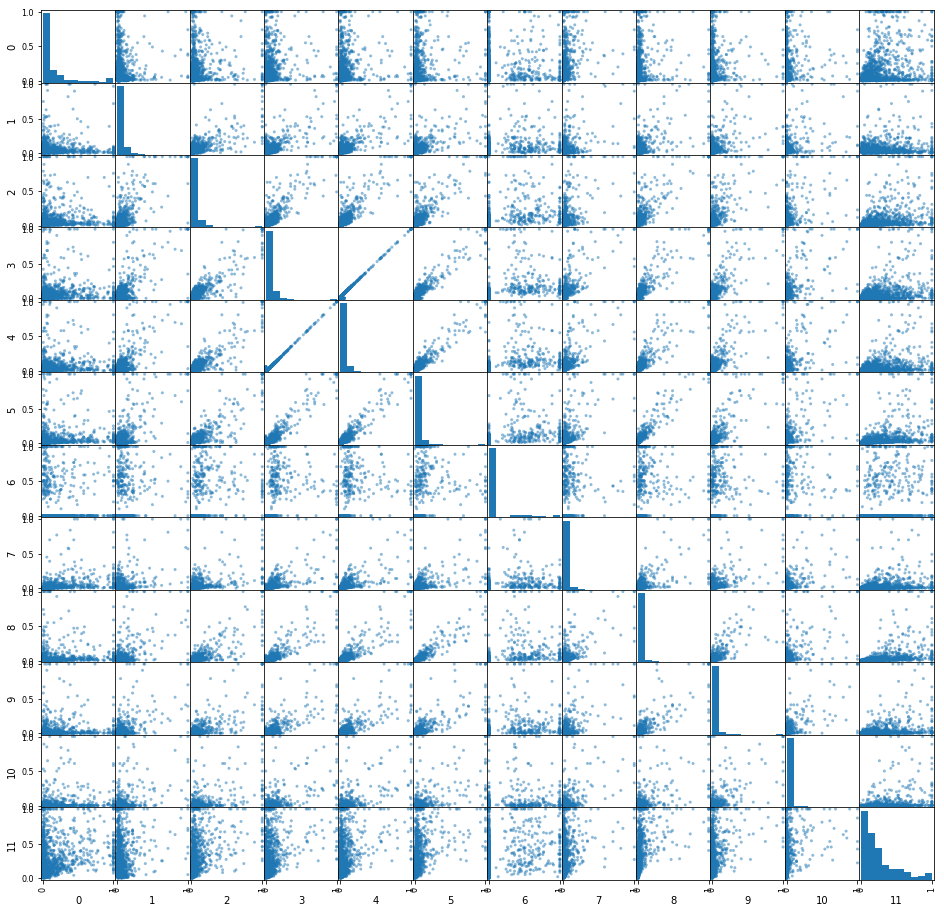

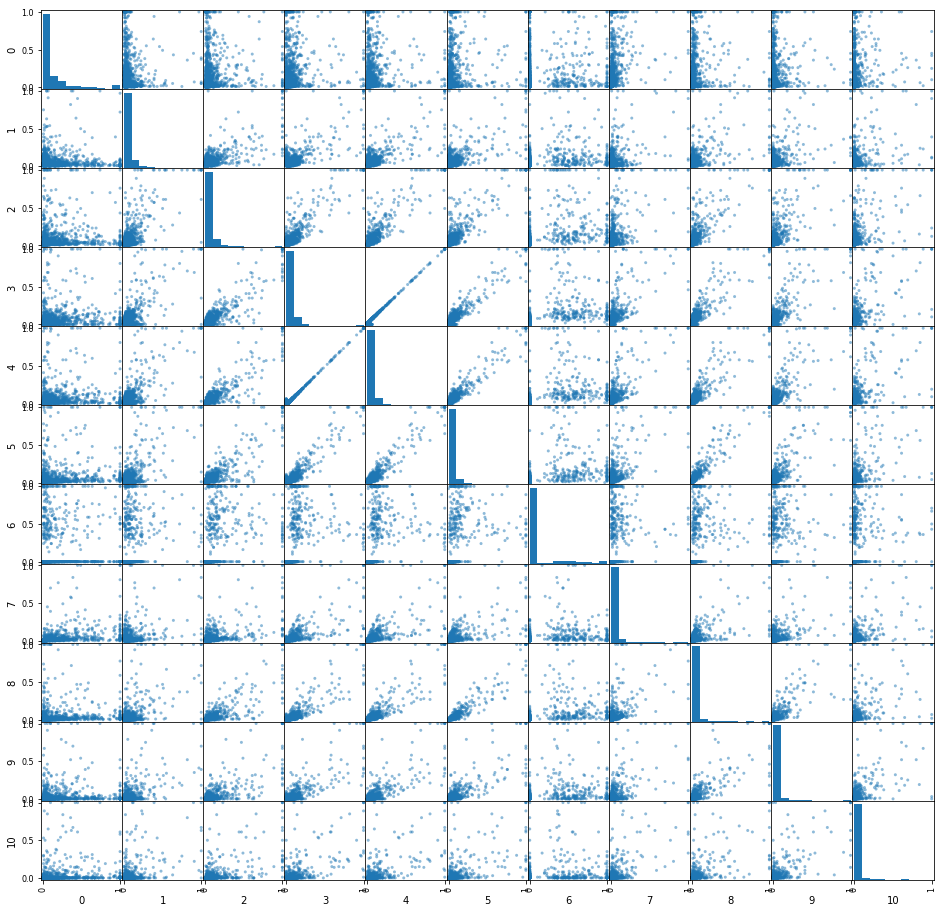

In [6]:
#variation method calculates the coefficient of variance in the form of 
#standard deviation / mean
cv = variation(train_imputed)

n_features = int(np.floor(np.sqrt(128)))
# n_features = 12

highest_cv_features = train_imputed[:, np.argsort(cv)[-n_features:]]
highest_cv_features_label = np.c_[highest_cv_features, label_training.reshape(-1, 1)]
highest_cv_features_label = pd.DataFrame(highest_cv_features_label)


scatter_matrix(highest_cv_features_label, figsize=(16,16))

highest_cv_features = pd.DataFrame(highest_cv_features)
# print(highest_cv_features_label)

scatter_matrix(highest_cv_features, figsize=(16,16))



# Linear Regression Model

In [7]:
cv = variation(train_imputed)
n_features = int(np.floor(np.sqrt(128)))
index_features = np.argsort(cv)[-n_features:]

train_selected = train_imputed[:, index_features]
test_selected = test_imputed[:, index_features]

lr = LinearRegression()
lr.fit(train_selected, label_training)
label_predicted = lr.predict(test_selected)

print(lr.coef_)
# print(label_predicted)
# print(label_testing)
MSE = mean_squared_error(label_testing ,label_predicted)

print('MSE %.5f' % MSE)

[ 0.2378753  -0.17473943  0.55079493 -0.07899667 -1.21911937  0.47660787
  0.17120546 -0.20900673  0.9589778   0.04776424  0.29554863]
MSE 0.02926


In [8]:
r_square = lr.score(test_selected, label_testing)
r_square

0.38476863162746866

# LASSO and Ridge Regression

the data is not normalized

In [9]:
# alpha = [0.1, 1, 10, 100]
# alpha = np.arange(1, 100, 5)
alpha = np.logspace(-4, 2, 15)
lasso_lr = LassoCV(alphas=alpha, cv=10)
lasso_lr_norm = LassoCV(alphas=alpha, normalize=True, cv=10)

ridge_lr = RidgeCV(alphas=alpha, cv=10)

classifiers = [lasso_lr, lasso_lr_norm, ridge_lr]
clf_names = ['lasso lr', 'lasso lr normalized','ridge lr']

for clf, name in zip(classifiers, clf_names):
    clf.fit(train_selected, label_training)
    clf.predict(test_selected)

    label_predicted = clf.predict(test_selected)
    MSE = mean_squared_error(label_testing, label_predicted)

    print('%s MSE %.5f' % (name, MSE))


lasso lr MSE 0.02910
lasso lr normalized MSE 0.02931
ridge lr MSE 0.02919


# PCA

PCA is performed using selected training data and testing data

In [10]:
def pca_train(X_train, X_test, y_train, y_test, n_component):
    pca = PCA(n_components=n_component)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_predicted = lr.predict(X_test)

    mse = mean_squared_error(y_test, y_predicted) 
    return mse

n_components = np.arange(1, n_features, 1)

kf = KFold(n_splits=5)

mse_cv = np.array([])
#cross valication on validation set
for n_component in n_components:
    
    mse_eachfold = np.array([])
    for train, test in kf.split(train_selected):
        X_train, X_test, y_train, y_test = train_selected[train, :], train_selected[test, :], label_training[train], label_training[test]
#         print(len(train), len(test))
        mse = pca_train(X_train, X_test, y_train, y_test, n_component)
        
        mse_eachfold = np.append(mse_eachfold, mse)
    
    mse_cv = np.append(mse_cv, np.mean(mse_eachfold))
    
print(mse_cv)
optimal_n_component = n_components[np.argmin(mse_cv)]
print('optimal number of components %d' % optimal_n_component)

print('optimal mse %.5f' % pca_train(train_selected, test_selected, label_training, label_testing, optimal_n_component))





[ 0.04414759  0.04296501  0.04295841  0.04291802  0.04158743  0.03894716
  0.03873502  0.03866984  0.03754089  0.03774859]
optimal number of components 9
optimal mse 0.02922


PCA is performed using original data

In [11]:
n_components = np.arange(1, train_imputed.shape[1], 10)

kf = KFold(n_splits=5)

mse_cv = np.array([])
#cross valication on validation set
for n_component in n_components:
    
    mse_eachfold = np.array([])
    for train, test in kf.split(train_imputed):
        X_train, X_test, y_train, y_test = train_imputed[train, :], train_imputed[test, :], label_training[train], label_training[test]
#         print(len(train), len(test))
        mse = pca_train(X_train, X_test, y_train, y_test, n_component)
        
        mse_eachfold = np.append(mse_eachfold, mse)
    
    mse_cv = np.append(mse_cv, np.mean(mse_eachfold))
    
print(mse_cv)
optimal_n_component = n_components[np.argmin(mse_cv)]
print('optimal number of components %d' % optimal_n_component)

print('optimal mse %.5f' % pca_train(train_imputed, test_imputed, label_training, label_testing, optimal_n_component))



[ 0.03790095  0.02001046  0.02027903  0.01990308  0.01996262  0.01986969
  0.01976377  0.01972806  0.01974705  0.01946261  0.01957579  0.01987876
  0.02054914]
optimal number of components 91
optimal mse 0.01839


# XGBoost

at each leaf, a l1-norm linear regression model is trained.

In [12]:
import xgboost as xgb

from sklearn.model_selection import cross_val_score

In [17]:
train_imputed

array([[ 0.19      ,  0.33      ,  0.02      , ...,  0.5       ,
         0.32      ,  0.14      ],
       [ 0.        ,  0.16      ,  0.12      , ...,  0.45188285,
         0.        ,  0.19075314],
       [ 0.        ,  0.42      ,  0.49      , ...,  0.45188285,
         0.        ,  0.19075314],
       ..., 
       [ 0.01      ,  0.36      ,  0.95      , ...,  0.45188285,
         0.        ,  0.19075314],
       [ 0.06      ,  0.53      ,  0.01      , ...,  0.45188285,
         0.        ,  0.19075314],
       [ 0.05      ,  0.43      ,  0.08      , ...,  0.        ,
         0.51      ,  0.18      ]])

In [18]:
alphas = np.logspace(-4, 2, 15)

# X_ = np.arange(10000).reshape(250, 40).astype(np.float)
# y_ = np.arange(250)
# print(X_.dtype)

# clf = xgb.XGBRegressor(reg_alpha=1, reg_lambda=0)
# clf = xgb.XGBClassifier()
# clf.fit(X_, y_)
# label_predicted = clf.predict(X_)
# mse = mean_squared_error(label_predicted, y_)

xgb_r = []
for alpha in alphas:
    clf = xgb.XGBRegressor(reg_alpha=alpha, reg_lambda=0)
    xgb_r.append(np.mean(cross_val_score(clf, train_imputed, label_training, cv=10)))

# clf = xgb.XGBRegressor(reg_alpha=1, reg_lambda=0)
# clf.fit(train_imputed, label_training)
# label_predicted = clf.predict(test_imputed)
# mse = mean_squared_error(label_predicted, label_testing)

xgb_r

[0.6426859187915257,
 0.64338520517486619,
 0.64055693042314221,
 0.64454302770239746,
 0.64314820131916717,
 0.64240521942929552,
 0.64383152986972791,
 0.64908402873267557,
 0.64911669475893219,
 0.64968170854992824,
 0.64775686769347873,
 0.64325734578789873,
 0.60709844516163114,
 0.52905748875646075,
 0.36963543518899378]

* xscale function

    Alter the scale of x axis


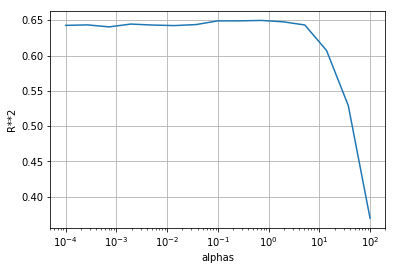

In [19]:
plt.figure()
plt.xscale('log')
plt.xlabel('alphas')
plt.ylabel('R**2')
plt.plot(alphas, xgb_r)
plt.grid(True)

plt.show()


In [20]:
xgb_clf = xgb.XGBRegressor(reg_alpha=1, reg_lambda=0)
xgb_clf.fit(train_imputed, label_training)
label_predicted = xgb_clf.predict(test_imputed)
mse = mean_squared_error(label_predicted, label_testing)

mse

0.016850819491914807